# 1. VAR Process

In the data `raotb16.csv` we have some macroeconomic data.

1. Test which series Granger cause each other.

2. Test which series are stationary

3. Fit a VAR on the system of time series. Find the best number of lags. Don't forget to differentiate the series that need it.

4. Fit a VAR on everything except the last 12 months (4 quarters) of the data. Backtest your model against the actual last year in the data. Plot the predictions against the data for each series.

In [1]:
# Notes
# Vector Autoregression (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other.

In [26]:
# ref: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# ref : https://link.springer.com/chapter/10.1007/978-1-349-23529-2_5
# ref : https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
matplotlib.style.use('ggplot')

sns.set()

In [3]:
df = pd.read_csv('data/raotb16.csv', parse_dates=['date'], index_col='date')
df

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0


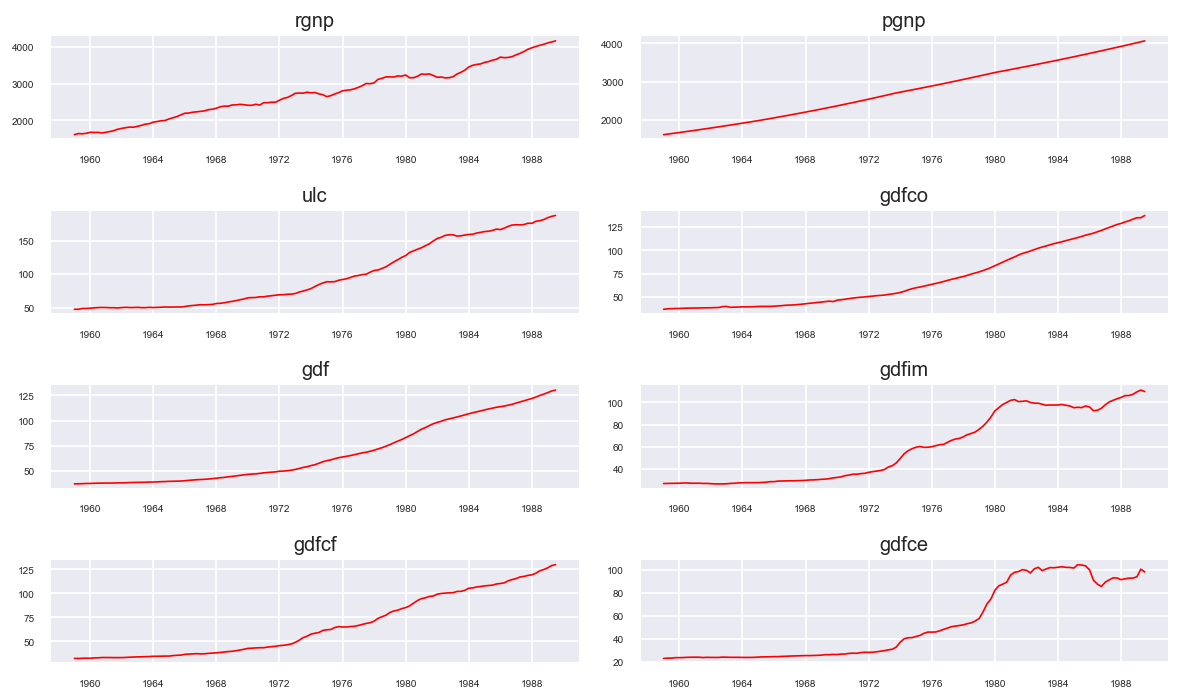

In [4]:
# Plot
fig, axes = plt.subplots(4, 2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)

    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### 1. Test which series Granger cause each other.

In [5]:
# ref: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    df2 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            min_p_index = np.argmin(p_values)
            df.loc[r, c] = min_p_value
            df2.loc[r, c] = min_p_index
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df,df2

In [6]:
R1, R2 = grangers_causation_matrix(df, variables = df.columns)
R1

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


In [7]:
# the above matrix displays the p-values calculated between all possible combinations
# based on the matrix of p-values, nearly all values are less than 0.05, 
# there we can reject the null hypothesis and conclude that the all series granger cause the next with the exception of gdfim_x on rgnp_y, with a p-value of 0.0620

In [8]:
R2

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
rgnp,0.0,10.0,3.0,9.0,11.0,11.0,7.0,8.0
pgnp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ulc,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
gdfco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
gdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
gdfim,0.0,0.0,1.0,1.0,8.0,0.0,11.0,0.0
gdfcf,0.0,0.0,0.0,0.0,0.0,10.0,0.0,6.0
gdfce,4.0,0.0,3.0,1.0,1.0,0.0,9.0,0.0


In [9]:
# the above matrix indicates the best lags for each combination of time series

In [10]:
# test df series (no differentiation)

#### 2. Test which series are stationary

In [11]:
from statsmodels.tsa.stattools import adfuller

for i in range(len(df.columns)):
    pvalue = adfuller(df[df.columns[i]], autolag='AIC')[1]
    lags = adfuller(df[df.columns[i]], autolag='AIC')[2]
    if pvalue <0.05:
        print(f'p-value = {pvalue}, therefore {df.columns[i]} is stationary. Lags used {lags}.')
    else:
        print(f'p-value = {pvalue}, therefore {df.columns[i]} is not stationary. Lags used {lags}.') 

p-value = 0.9886037114305949, therefore rgnp is not stationary. Lags used 2.
p-value = 0.9964612064726063, therefore pgnp is not stationary. Lags used 1.
p-value = 0.9970991728829679, therefore ulc is not stationary. Lags used 2.
p-value = 0.9870138472785788, therefore gdfco is not stationary. Lags used 5.
p-value = 0.9953249001658119, therefore gdf is not stationary. Lags used 7.
p-value = 0.9386740229058368, therefore gdfim is not stationary. Lags used 1.
p-value = 0.998051164027281, therefore gdfcf is not stationary. Lags used 9.
p-value = 0.814401530750196, therefore gdfce is not stationary. Lags used 13.


#### 3. Fit a VAR on the system of time series. Find the best number of lags. Don't forget to differentiate the series that need it.

In [12]:
# differencing 1 time
df_train, df_test = df[0:-4], df[-4:]

In [13]:
df_differenced = df_train.diff().dropna()

for i in range(len(df_differenced.columns)):
    pvalue = adfuller(df_differenced[df_differenced.columns[i]], autolag='AIC')[1]
    lags = adfuller(df_differenced[df_differenced.columns[i]], autolag='AIC')[2]
    if pvalue <0.05:
        print(f'p-value = {pvalue}, therefore {df_differenced.columns[i]} is stationary. Lags used {lags}.')
    else:
        print(f'p-value = {pvalue}, therefore {df_differenced.columns[i]} is not stationary. Lags used {lags}.') 

p-value = 4.419602687789637e-06, therefore rgnp is stationary. Lags used 1.
p-value = 0.3665720098063817, therefore pgnp is not stationary. Lags used 0.
p-value = 0.008911226559340485, therefore ulc is stationary. Lags used 1.
p-value = 0.5636992383756486, therefore gdfco is not stationary. Lags used 2.
p-value = 0.7034008289397009, therefore gdf is not stationary. Lags used 2.
p-value = 0.0008781918709295949, therefore gdfim is stationary. Lags used 0.
p-value = 0.263200683830167, therefore gdfcf is not stationary. Lags used 7.
p-value = 0.022785864576444992, therefore gdfce is stationary. Lags used 7.


In [14]:
# differencing 2 times

In [15]:
df_differenced = df_differenced.diff().dropna()

for i in range(len(df_differenced.columns)):
    pvalue = adfuller(df_differenced[df_differenced.columns[i]], autolag='AIC')[1]
    lags = adfuller(df_differenced[df_differenced.columns[i]], autolag='AIC')[2]
    if pvalue <0.05:
        print(f'p-value = {pvalue}, therefore {df_differenced.columns[i]} is stationary. Lags used {lags}.')
    else:
        print(f'p-value = {pvalue}, therefore {df_differenced.columns[i]} is not stationary. Lags used {lags}.') 

p-value = 6.079382033284247e-15, therefore rgnp is stationary. Lags used 2.
p-value = 7.447101866633e-20, therefore pgnp is stationary. Lags used 0.
p-value = 2.551561644451376e-14, therefore ulc is stationary. Lags used 2.
p-value = 3.966523712958817e-12, therefore gdfco is stationary. Lags used 3.
p-value = 1.5481624948080196e-17, therefore gdf is stationary. Lags used 1.
p-value = 6.012153991319648e-16, therefore gdfim is stationary. Lags used 1.
p-value = 1.1400745207134384e-09, therefore gdfcf is stationary. Lags used 5.
p-value = 9.971605461584714e-06, therefore gdfce is stationary. Lags used 8.


In [16]:
# as per dickey-fuller tests, all series were originally non-stationary
# in order to render all series stationary, series differenced twice

In [17]:
df_differenced

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-07-01,-38.1,0.1,1.2,-3.000000e-01,0.0,0.0,0.3,-0.3
1959-10-01,21.4,0.1,-1.1,-1.000000e-01,0.1,-0.1,-0.1,0.4
1960-01-01,14.3,0.2,0.2,-7.105427e-15,-0.2,0.1,-0.2,-0.4
1960-04-01,-33.0,0.1,0.2,1.000000e-01,0.2,0.1,0.5,0.1
1960-07-01,6.4,0.1,-0.1,-1.000000e-01,-0.1,-0.2,-0.3,0.1
...,...,...,...,...,...,...,...,...
1987-07-01,8.8,0.1,0.7,-1.000000e-01,0.0,-1.0,-1.0,-0.1
1987-10-01,13.5,0.1,1.4,1.000000e-01,0.1,-0.1,0.4,-2.0
1988-01-01,-23.6,0.2,-2.0,-5.000000e-01,-0.1,-0.2,-0.3,-1.2


In [18]:
# fit var model

In [19]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

model = VAR(df_differenced)

C:\Users\gayar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In [20]:
# find best number of lags

In [21]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.07898,0.1232,0.9241,0.002961
1,-0.5721,1.248,0.5662,0.1653
2,-0.8256,2.612,0.4482,0.5674
3,-1.007,4.048,0.3937,1.042
4,-1.255,5.418,0.3399,1.449
5,-1.230,7.060,0.4147,2.129
6,-1.739,8.169,0.3286,2.276
7,-2.142,9.384,0.3340,2.528
8,-2.964,10.18,0.2744,2.362
9,-4.562,10.20,0.1413,1.420


In [22]:
# as per the AIC, the best lag is 3

In [23]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Apr, 2021
Time:                     22:04:33
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    3.03455
Nobs:                     114.000    HQIC:                  0.182391
Log likelihood:          -993.421    FPE:                   0.181251
AIC:                     -1.76580    Det(Omega_mle):       0.0371023
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.860547         2.551123            1.121           0.262
L1.rgnp         -0.766097         0.126289           -6.066           0.000
L1.pgnp          0.422102         4.809104            0.088           0.930
L1.ul

#### 4. Fit a VAR on everything except the last 12 months (4 quarters) of the data. Backtest your model against the actual last year in the data. Plot the predictions against the data for each series.

In [26]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[-23.6,   0.2,  -2. ,  -0.5,  -0.1,  -0.2,  -0.3,  -1.2],
       [ -3.3,   0.1,   3.1,   0.5,   0.3,   0.4,   0.9,   2.2],
       [ -3.9,   0.2,  -2.1,  -0.4,   0.2,  -1.5,   0.9,  -0.3]])

In [29]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=4)
df_forecast = pd.DataFrame(fc, index=df.index[-4:], columns=df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,55.801216,1.087823,0.471679,0.324337,-0.126750,0.483579,-0.906001,-1.193403
1989-01-01,-57.218412,-0.387633,-0.202911,-0.194556,0.123534,0.674926,0.601623,2.994860
1989-04-01,56.548652,0.462676,0.068321,0.072947,-0.307776,0.069792,-0.312660,-1.639759
1989-07-01,-53.349939,-0.240287,0.234213,-0.107179,0.259264,-0.617205,-0.095550,-0.326148


In [30]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [32]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4130.501216,3996.787823,180.971679,133.024337,126.373250,106.783579,125.093999,92.106597
1989-01-01,4161.084021,4021.288013,182.140448,134.354118,127.970034,108.042084,127.289620,94.408053
1989-04-01,4248.215478,4046.250879,183.377538,135.756845,129.259042,109.370382,129.172582,95.069751
1989-07-01,4281.996995,4070.973458,184.848841,137.052394,130.807314,110.081475,130.959994,95.405301


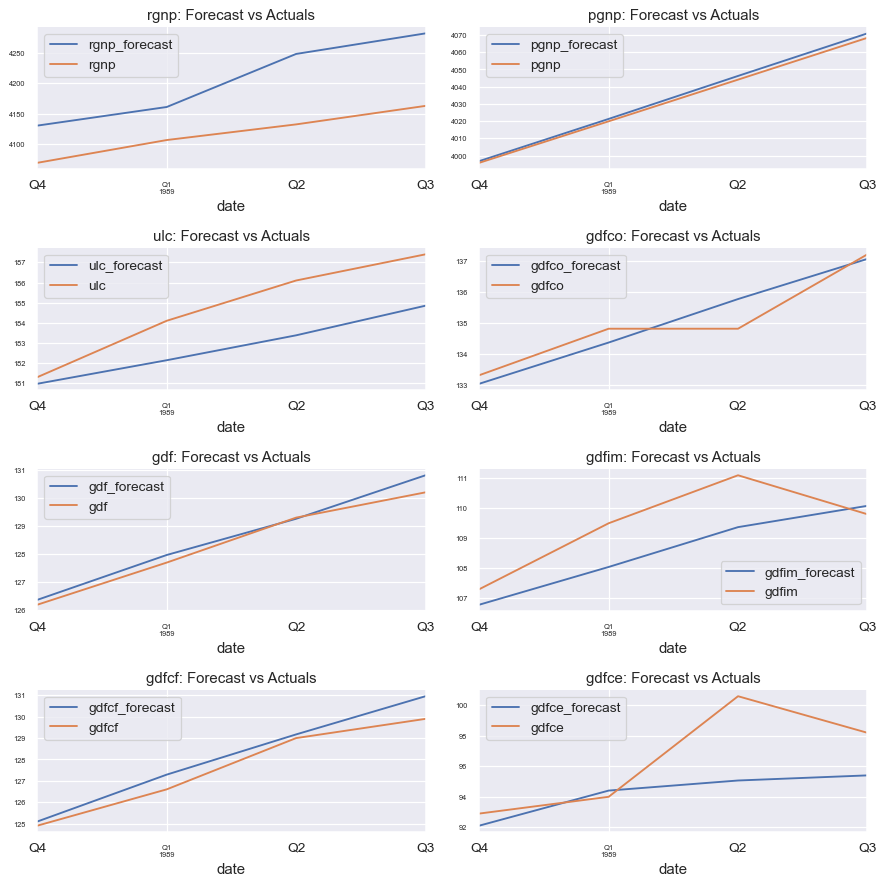

In [38]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=90, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-4:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# 2. Gun Violence Panel

The [Gun Violence](https://www.kaggle.com/jameslko/gun-violence-data) dataset

1. Transform it into an amenable panel (or structure of multiple time series) to analyze and create a forecast for the next year outside the sample in **Chicago**, **Washington** and **New Orleans**, and the US as a whole.

2. Are there other (non time series) predictors which could be used in this dataset to help predict severity or number of shootings in the future? Analyze the data for feature importance and explain your findings.

In [ ]:
# ref : https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8

In [2]:
import pandas as pd
gv = pd.read_csv('data\GunViolenceData.csv')
list(gv.columns)
gv.describe()

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
count,2.396770e+05,239677.000000,239677.000000,227733.000000,231754.000000,231754.000000,140226.000000,200905.000000,207342.00000
mean,5.593343e+05,0.252290,0.494007,8.001265,37.546598,-89.338348,1.372442,55.447132,20.47711
std,2.931287e+05,0.521779,0.729952,8.480835,5.130763,14.359546,4.678202,42.048117,14.20456
min,9.211400e+04,0.000000,0.000000,0.000000,19.111400,-171.429000,1.000000,1.000000,1.00000
25%,3.085450e+05,0.000000,0.000000,2.000000,33.903400,-94.158725,1.000000,21.000000,9.00000
50%,5.435870e+05,0.000000,0.000000,5.000000,38.570600,-86.249600,1.000000,47.000000,19.00000
75%,8.172280e+05,0.000000,1.000000,10.000000,41.437375,-80.048625,1.000000,84.000000,30.00000
max,1.083472e+06,50.000000,53.000000,53.000000,71.336800,97.433100,400.000000,901.000000,94.00000


In [3]:
gv.isnull().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

In [37]:
import pandas as pd
gv = pd.read_csv('data\GunViolenceData.csv')
gv = gv[['date','state','city_or_county','n_killed','n_injured']]#'gun_stolen','n_guns_involved','participant_age','participant_gender','participant_status','participant_type']]
gv['date']= pd.to_datetime(gv['date'])
gv = gv.set_index('date')
# gv['year'] = pd.to_datetime(gv['date'], errors='coerce', format='%Y')
gv['ym'] = gv.index.to_period('M')
gv = gv.set_index('ym')
gv

,state,city_or_county,n_killed,n_injured
ym,,,,
2013-01,Pennsylvania,Mckeesport,0,4
2013-01,California,Hawthorne,1,3
2013-01,Ohio,Lorain,1,3
2013-01,Colorado,Aurora,4,0
2013-01,North Carolina,Greensboro,2,2
...,...,...,...,...
2018-03,Louisiana,Rayne,0,0
2018-03,Louisiana,Natchitoches,1,0
2018-03,Louisiana,Gretna,0,1


In [45]:
gv_ch = gv[gv['city_or_county']=='Chicago']
gv_ch = gv_ch[['n_killed','n_injured']]
gv_ch = gv_ch.groupby(["ym"]).sum().reset_index()
gv_ch = gv_ch.set_index('ym')
gv_ch = gv_ch.loc['2013-01':'2018-12']

model = VAR(gv_ch)
results = model.fit(maxlags=12)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Apr, 2021
Time:                     23:47:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.9967
Nobs:                     46.0000    HQIC:                   12.7537
Log likelihood:          -356.751    FPE:                    213517.
AIC:                      12.0091    Det(Omega_mle):         89625.3
--------------------------------------------------------------------
Results for equation n_killed
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 3.987045        13.156169            0.303           0.762
L1.n_killed          -0.073631         0.321420           -0.229           0.819
L1.n_injured          0.091181         0.074780          

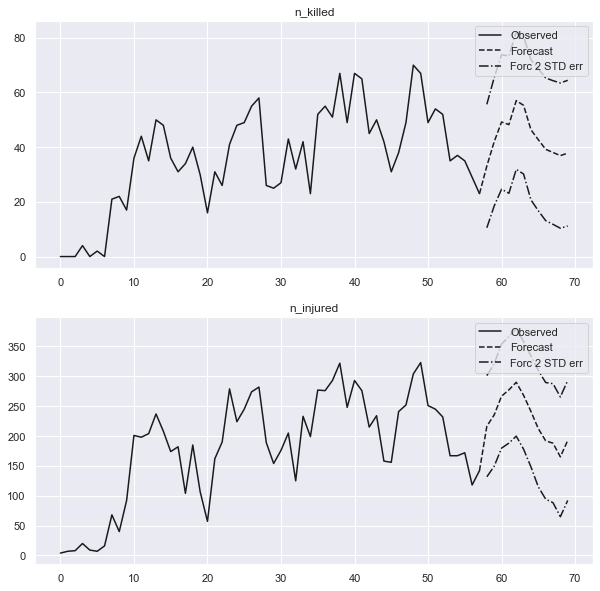

In [46]:
# Chicago
results.plot_forecast(12);

In [44]:
gv_ws = gv[gv['city_or_county']=='Washington']
gv_ws = gv_ws[['n_killed','n_injured']]
gv_ws = gv_ws.groupby(["ym"]).sum().reset_index()
gv_ws = gv_ws.set_index('ym')
gv_ws = gv_ws.loc['2013-01':'2018-12']

model = VAR(gv_ws)
results = model.fit(maxlags=12)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Apr, 2021
Time:                     23:47:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.17954
Nobs:                     44.0000    HQIC:                   6.90394
Log likelihood:          -210.212    FPE:                    638.207
AIC:                      6.15205    Det(Omega_mle):         259.519
--------------------------------------------------------------------
Results for equation n_killed
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -5.722711         6.532120           -0.876           0.381
L1.n_killed          -0.234286         0.217780           -1.076           0.282
L1.n_injured          0.082463         0.080564          

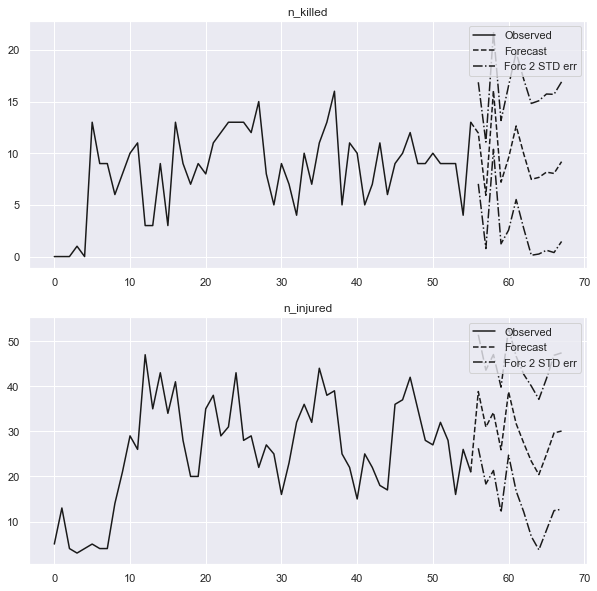

In [41]:
# Washington
results.plot_forecast(12);

In [47]:
gv_no = gv[gv['city_or_county']=='New Orleans']
gv_no = gv_no[['n_killed','n_injured']]
gv_no = gv_no.groupby(["ym"]).sum().reset_index()
gv_no = gv_no.set_index('ym')
gv_no = gv_no.loc['2013-01':'2018-12']

model = VAR(gv_no)
results = model.fit(maxlags=12)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Apr, 2021
Time:                     23:50:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.8232
Nobs:                     43.0000    HQIC:                   9.53052
Log likelihood:          -260.698    FPE:                    9027.23
AIC:                      8.77531    Det(Omega_mle):         3609.72
--------------------------------------------------------------------
Results for equation n_killed
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                16.783931         9.232191            1.818           0.069
L1.n_killed           0.207672         0.249126            0.834           0.405
L1.n_injured          0.113744         0.123575          

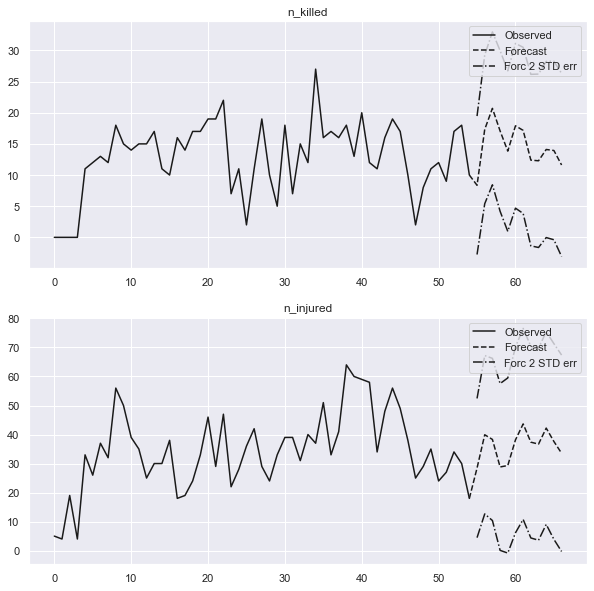

In [48]:
# New Orleans
results.plot_forecast(12);

In [72]:
gv_us = gv[['n_killed','n_injured']]
gv_us = gv_no.groupby(["ym"]).sum().reset_index()
gv_us = gv_us.set_index('ym')
gv_us = gv_us.loc['2013-01':'2018-12']
gv_us.head()

,n_killed,n_injured
ym,,
2013-01,0,5
2013-02,0,4
2013-05,0,19
2013-06,0,4
2014-01,11,33


In [53]:
model = VAR(gv_us)
results = model.fit(maxlags=12)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, May, 2021
Time:                     00:06:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.8232
Nobs:                     43.0000    HQIC:                   9.53052
Log likelihood:          -260.698    FPE:                    9027.23
AIC:                      8.77531    Det(Omega_mle):         3609.72
--------------------------------------------------------------------
Results for equation n_killed
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                16.783931         9.232191            1.818           0.069
L1.n_killed           0.207672         0.249126            0.834           0.405
L1.n_injured          0.113744         0.123575          

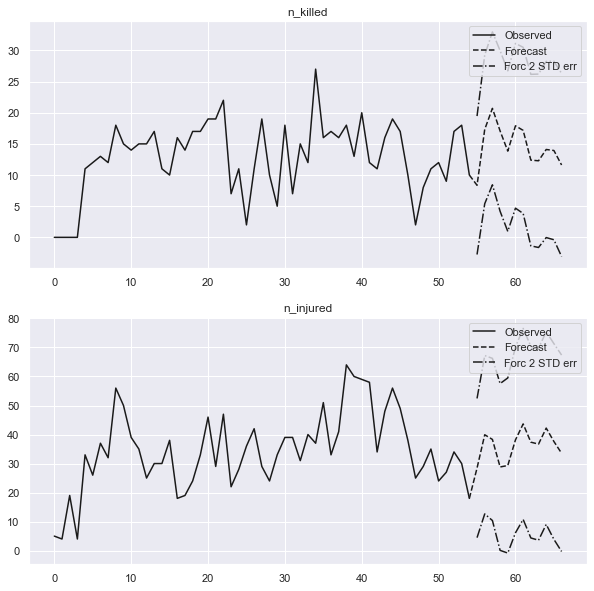

In [55]:
results.plot_forecast(12);

In [73]:
gv_us['country'] = 'US'
gv_us.reset_index(inplace=True)
gv_us = gv_us.set_index(['country','ym'])
gv_us.head()

n_killed  n_injured
country ym                          
US      2013-01         0          5
        2013-02         0          4
        2013-05         0         19
        2013-06         0          4
        2014-01        11         33

In [ ]:
# exog_vars = ['n_injured']
# exog = sm.add_constant(gv_us[exog_vars])
# mod = PooledOLS(gv_us['n_killed'], exog)
# pooled_res = mod.fit()
# print(pooled_res)

In [15]:
# gv = pd.read_csv('data\GunViolenceData.csv', usecols = ['date','state','city_or_county','n_killed','n_injured'])
dataset = pd.read_csv('data\GunViolenceData.csv')
dataset['date']= pd.to_datetime(dataset['date'])
# dataset['month_yr'] = dataset['date'].dt.to_period('M') 
dataset = dataset.set_index(['incident_id','date'])
date = dataset.index.get_level_values('date').to_list()
dataset['date'] = pd.Categorical(date)
dataset.sample(5)

,,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,date
incident_id,date,,,,,,,,,,,,,,,,,,,,,
766336,2017-02-02,Ohio,Newark,4300 block of Price Road,2,0,http://www.gunviolencearchive.org/incident/766336,http://www.dispatch.com/news/20170203/two-dead...,False,12.0,0::Unknown,...,0::Adult 18+||1::Adult 18+,0::Female||1::Male,0::Elizabeth Lewandowski||1::David Lewandowski,NaN,0::Killed||1::Killed,0::Victim||1::Subject-Suspect,http://www.newarkadvocate.com/story/news/crime...,71.0,31.0,2017-02-02
593115,2016-07-01,Rhode Island,Providence,18 East Transit Street,0,1,http://www.gunviolencearchive.org/incident/593115,http://www.providencejournal.com/news/20160701...,False,1.0,0::Unknown,...,0::Adult 18+||1::Adult 18+,0::Male||1::Male,NaN,1::Armed Robbery,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,http://turnto10.com/news/local/man-shot-during...,2.0,3.0,2016-07-01
641847,2016-08-29,Massachusetts,Worcester,Endicott St,0,1,http://www.gunviolencearchive.org/incident/641847,http://www.necn.com/news/new-england/Worcester...,False,2.0,0::Unknown||1::Unknown,...,0::Adult 18+||1::Adult 18+||2::Adult 18+,0::Male||1::Male||2::Male,NaN,NaN,0::Injured||1::Unharmed||2::Unharmed,0::Victim||1::Subject-Suspect||2::Subject-Suspect,http://www.necn.com/news/new-england/Worcester...,NaN,NaN,2016-08-29
119046,2014-03-26,Florida,Miami-dade,150th Avenue and Southwest 88th Street,0,1,http://www.gunviolencearchive.org/incident/119046,http://www.local10.com/news/man-calls-911-says...,False,27.0,NaN,...,0:Adult 18+,0:Male,0:Rojelio Orozco,NaN,0:Injured,0:Victim,http://www.local10.com/news/man-calls-911-says...,115.0,35.0,2014-03-26
302512,2015-03-07,Georgia,Atlanta,812 Ralph David Abernathy Boulevard,1,0,http://www.gunviolencearchive.org/incident/302512,http://www.ajc.com/news/news/breaking-news/man...,False,5.0,NaN,...,0::Adult 18+,0::Male,0::Martrell Gay,NaN,0::Killed,0::Victim,http://www.wsbtv.com/news/news/local/man-fatal...,57.0,36.0,2015-03-07


In [ ]:
# !pip install linearmodels

In [22]:
# Chicago

gv_ch = dataset[dataset['city_or_county']=="Chicago"]

from linearmodels.panel import PooledOLS
import statsmodels.api as sm

exog_vars = ['state','city_or_county','n_injured']
exog = sm.add_constant(gv_ch[exog_vars])
mod = PooledOLS(gv_ch['n_killed'], exog)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:               n_killed   R-squared:                        0.1549
Estimator:                  PooledOLS   R-squared (Between):              0.1549
No. Observations:               10814   R-squared (Within):               0.0000
Date:                Fri, Apr 30 2021   R-squared (Overall):              0.1549
Time:                        23:29:25   Log-likelihood                   -5184.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1982.4
Entities:                      239645   P-value                           0.0000
Avg Obs:                       0.0451   Distribution:                 F(1,10812)
Min Obs:                       0.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             1982.4
                            

In [30]:
# Washington

gv_ch = dataset[dataset['city_or_county']=="Washington"]

from linearmodels.panel import PooledOLS
import statsmodels.api as sm

exog_vars = ['state','city_or_county','n_injured']
exog = sm.add_constant(gv_ch[exog_vars])
mod = PooledOLS(gv_ch['n_killed'], exog)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:               n_killed   R-squared:                        0.0198
Estimator:                  PooledOLS   R-squared (Between):              0.0198
No. Observations:                3279   R-squared (Within):               0.0000
Date:                Fri, Apr 30 2021   R-squared (Overall):              0.0198
Time:                        23:34:17   Log-likelihood                   -1338.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4.1242
Entities:                      239675   P-value                           0.0000
Avg Obs:                       0.0137   Distribution:                 F(16,3262)
Min Obs:                       0.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             4.1242
                            

In [24]:
# New Orleans

gv_ch = dataset[dataset['city_or_county']=="New Orleans"]

from linearmodels.panel import PooledOLS
import statsmodels.api as sm

exog_vars = ['state','city_or_county','n_injured']
exog = sm.add_constant(gv_ch[exog_vars])
mod = PooledOLS(gv_ch['n_killed'], exog)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:               n_killed   R-squared:                        0.0315
Estimator:                  PooledOLS   R-squared (Between):              0.0315
No. Observations:                3071   R-squared (Within):               0.0000
Date:                Fri, Apr 30 2021   R-squared (Overall):              0.0315
Time:                        23:31:36   Log-likelihood                   -1929.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      49.904
Entities:                      239418   P-value                           0.0000
Avg Obs:                       0.0128   Distribution:                  F(2,3068)
Min Obs:                       0.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             49.904
                            

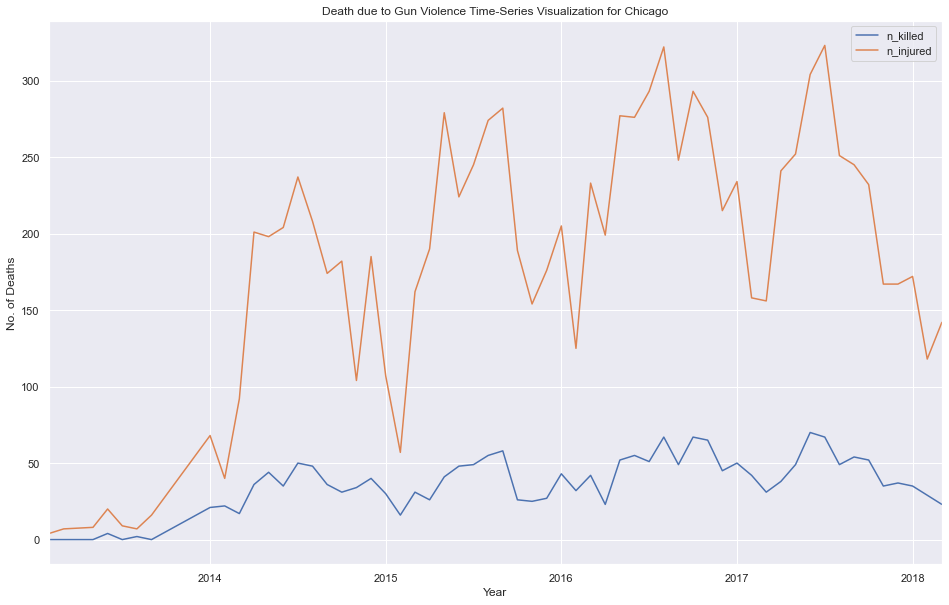

In [49]:
gv_ch = gv[gv['city_or_county']=='Chicago']
gv_ch = gv_ch[['n_killed','n_injured']]
gv_ch = gv_ch.groupby(["ym"]).sum().reset_index()
gv_ch = gv_ch.set_index('ym')
gv_ch = gv_ch.loc['2013-01':'2018-12']

gv_ch[['n_killed','n_injured']].plot(figsize = (16, 10))
plt.xlabel('Year')
plt.ylabel('No. of Deaths')
plt.title("Death due to Gun Violence Time-Series Visualization for Chicago")
plt.show()

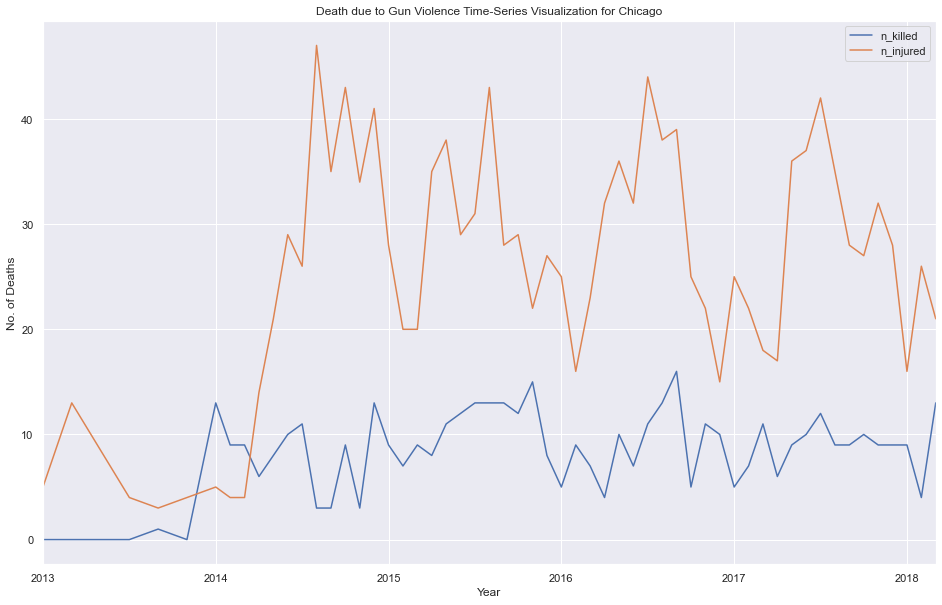

In [85]:
gv_ws = gv[gv['city_or_county']=='Washington']
gv_ws = gv_ws[['n_killed','n_injured']]
gv_ws = gv_ws.groupby(["ym"]).sum().reset_index()
gv_ws = gv_ws.set_index('ym')
gv_ws = gv_ws.loc['2013-01':'2018-12']

gv_ws[['n_killed','n_injured']].plot(figsize = (16, 10))
plt.xlabel('Year')
plt.ylabel('No. of Deaths')
plt.title("Death due to Gun Violence Time-Series Visualization for Chicago")
plt.show()

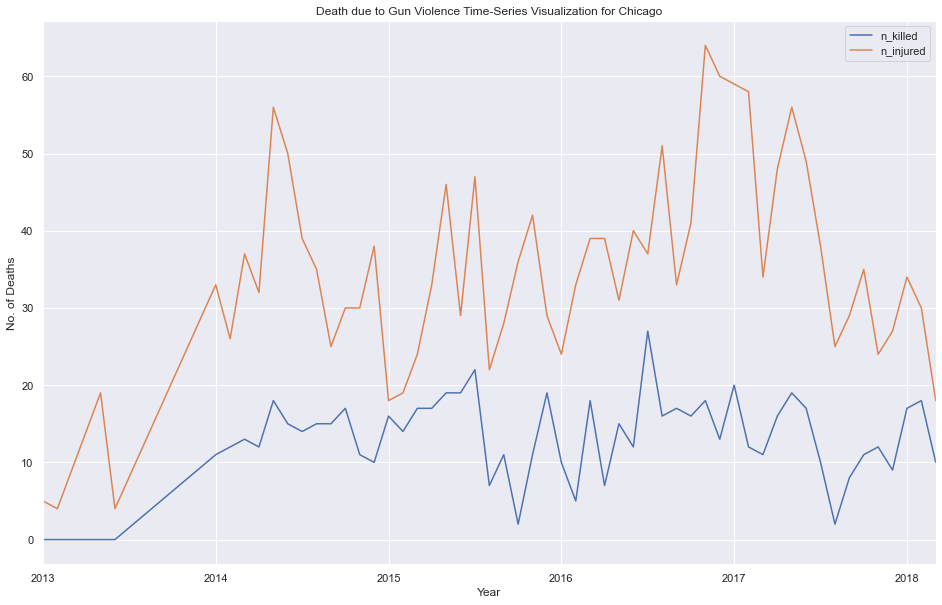

In [87]:
gv_no = gv[gv['city_or_county']=='New Orleans']
gv_no = gv_no[['n_killed','n_injured']]
gv_no = gv_no.groupby(["ym"]).sum().reset_index()
gv_no = gv_no.set_index('ym')
gv_no = gv_no.loc['2013-01':'2018-12']

gv_no[['n_killed','n_injured']].plot(figsize = (16, 10))
plt.xlabel('Year')
plt.ylabel('No. of Deaths')
plt.title("Death due to Gun Violence Time-Series Visualization for Chicago")
plt.show()

In [ ]:
# the original panel data is unabalanced, many of the potential predictors are missing data.
# the main predictors chosen for this analysis have no missing data and as such the subset of the panel data is balanced

# No null data

# incident_id                         0
# date                                0
# state                               0
# city_or_county                      0
# n_killed                            0
# n_injured                           0